In [1]:
# 实验 4: 引入不同的存储级别，分析对性能的影响
from pyspark.sql import SparkSession
import time
from pyspark import StorageLevel

# 初始化 Spark 会话
spark = SparkSession.builder.appName("StorageLevelExperiment").master("spark://ecnu01:7077") \
    .config("spark.executor.memory", "14g") \
    .config("spark.executor.cores", "16") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()
# spark = SparkSession.builder.appName("StorageLevelExperiment").getOrCreate()
sc = spark.sparkContext

# 创建一个大数据集
data = [(i, i) for i in range(10**7)]  # 10万条数据

# 创建 RDD
rdd = sc.parallelize(data)

# 测试不同的存储级别
# StorageLevel.MEMORY_ONLY_SER, StorageLevel.MEMORY_ONLY_2
for storage_level in [StorageLevel.MEMORY_ONLY,StorageLevel.MEMORY_AND_DISK, StorageLevel.MEMORY_ONLY_SER,StorageLevel.MEMORY_AND_DISK_SER,StorageLevel.DISK_ONLY]:
    print(f"\nTesting with storage level: {storage_level}")
    
    # 持久化 RDD
    rdd_persisted = rdd.persist(storage_level)
    
    # 执行一个宽依赖操作 (reduceByKey)
    start_time = time.time()
    rdd_persisted.reduceByKey(lambda x, y: x + y).collect()  # 触发行动操作
    end_time = time.time()
    
    print(f"Execution time with storage level {storage_level}: {end_time - start_time} seconds")
    rdd_persisted.unpersist()

sc.stop()



Testing with storage level: Memory Serialized 1x Replicated
Execution time with storage level Memory Serialized 1x Replicated: 8.406356573104858 seconds

Testing with storage level: Disk Memory Serialized 1x Replicated
Execution time with storage level Disk Memory Serialized 1x Replicated: 5.841069221496582 seconds

Testing with storage level: Memory Serialized 1x Replicated
Execution time with storage level Memory Serialized 1x Replicated: 5.2165443897247314 seconds

Testing with storage level: Disk Memory Serialized 1x Replicated
Execution time with storage level Disk Memory Serialized 1x Replicated: 5.176656246185303 seconds

Testing with storage level: Disk Serialized 1x Replicated
Execution time with storage level Disk Serialized 1x Replicated: 4.917440176010132 seconds


In [1]:
from pyspark.sql import SparkSession
import time
from pyspark import StorageLevel
from tqdm import tqdm

# 初始化 Spark 会话
spark = SparkSession.builder.appName("StorageLevelExperiment") \
    .master("spark://ecnu01:7077") \
    .config("spark.executor.memory", "14g") \
    .config("spark.executor.cores", "16") \
    .config("spark.executor.instances", "2") \
    .getOrCreate()
sc = spark.sparkContext

# 设置总数据量和每批次大小
total_data_size = 10**7  # 100万条数据
batch_size = 10**5       # 每个批次10万条数据
num_batches = (total_data_size + batch_size - 1) // batch_size  # 计算需要的批次数量

storage_level_names = [
    StorageLevel.MEMORY_ONLY,
    StorageLevel.MEMORY_AND_DISK,
    StorageLevel.MEMORY_ONLY_SER,
    StorageLevel.MEMORY_AND_DISK_SER,
    StorageLevel.DISK_ONLY
]
average_times = []

# 测试不同的存储级别
for storage_level in storage_level_names:
    print(f"\nTesting with storage level: {storage_level}")
    
    # 重复执行次数
    num_iterations = 1 #3
    total_time = 0
    
    for i in range(num_iterations):
        
        # 在每次迭代开始前取消持久化（如果有的话）
        if 'rdd_persisted' in locals():
            rdd_persisted.unpersist()

        # 对于每个存储级别，在每次迭代中重新创建并持久化RDD
        for batch_index in tqdm(range(num_batches), desc="Batch Progress"):
            start_idx = batch_index * batch_size
            end_idx = min(start_idx + batch_size, total_data_size)
            data_batch = [(j, j) for j in range(start_idx, end_idx)]  # 创建一个批次的数据
            
            # 创建 RDD 并适当增加分区数以优化 shuffle 操作
            rdd_batch = sc.parallelize(data_batch, numSlices=10)

            # 持久化 RDD
            rdd_persisted = rdd_batch.persist(storage_level)
            
            # 强制触发计算以确保数据被缓存
            rdd_persisted.count()
            
            # 执行多个操作以增加复杂性
            start_time = time.time()
            # 宽依赖操作1: reduceByKey
            result1 = rdd_persisted.reduceByKey(lambda x, y: x + y).collect() 
            # 宽依赖操作2: groupByKey
            result2 = rdd_persisted.groupByKey().collect() 
            # 宽依赖操作3: join
            result3 = rdd_persisted.join(rdd_persisted).collect()
            
            end_time = time.time()
            total_time += (end_time - start_time)
            
            # 取消持久化当前批次的RDD
            rdd_persisted.unpersist()

    # 计算平均执行时间
    average_time = total_time / (num_iterations)
    average_times.append(average_time)
    print(f"Average execution time with storage level {storage_level}: {average_time} seconds")

# 停止 Spark 会话
sc.stop()


Testing with storage level: Memory Serialized 1x Replicated


Batch Progress: 100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


Average execution time with storage level Memory Serialized 1x Replicated: 138.41379070281982 seconds

Testing with storage level: Disk Memory Serialized 1x Replicated


Batch Progress: 100%|██████████| 100/100 [02:33<00:00,  1.53s/it]


Average execution time with storage level Disk Memory Serialized 1x Replicated: 140.13149499893188 seconds

Testing with storage level: Memory Serialized 1x Replicated


Batch Progress: 100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


Average execution time with storage level Memory Serialized 1x Replicated: 143.42867302894592 seconds

Testing with storage level: Disk Memory Serialized 1x Replicated


Batch Progress: 100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


Average execution time with storage level Disk Memory Serialized 1x Replicated: 145.36133098602295 seconds

Testing with storage level: Disk Serialized 1x Replicated


Batch Progress: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it]


Average execution time with storage level Disk Serialized 1x Replicated: 152.59918236732483 seconds


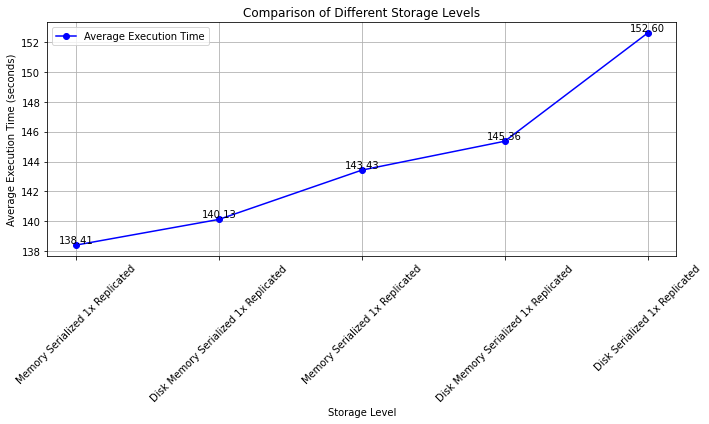

In [4]:
import matplotlib.pyplot as plt
import numpy as np
# 绘制折线图
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(storage_level_names))

# 折线图
plt.plot(x_pos, average_times, marker='o', linestyle='-', color='blue', label='Average Execution Time')

# 添加数值标签到点上
for i, v in enumerate(average_times):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# 设置X轴标签
plt.xticks(x_pos, storage_level_names, rotation=45)
plt.xlabel('Storage Level')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Comparison of Different Storage Levels')
plt.legend()
plt.grid(True)

# 保存图表
plt.tight_layout()
plt.savefig('storage_level_performance_line.png')
plt.show()